# Pitch Deck Image Dataset Exploration (part 2)

## Import Libraries

In [1]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

## Visualize any class imbalance.

In [2]:
image_dataset = './data/images'
target_classes = [str(i) for i in range(4, 9)]
class_count = []
company_names = []
slide_nums = []
image_paths = []
labels = []

for label in target_classes:
    label_path = os.path.join(image_dataset, label)
    count = len([image_path for image_path in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, image_path))])
    class_count.append(count)
    for image_path in os.listdir(label_path):
        if os.path.isfile(os.path.join(label_path, image_path)):
            #save image path and labels
            image_meta = image_path.split('.')
            company_names.append(image_meta[1])
            slide_nums.append(image_meta[2])
            labels.append(image_meta[0])
            image_paths.append(image_path)
df = pd.DataFrame(zip(company_names, slide_nums, labels, image_paths), columns=['Name', 'Slide', 'Label', 'Path'])

print(target_classes) #['4', '5', '6', '7', '8']
print(class_count) #[147, 831, 1240, 1355, 311]
print(len(image_paths)) #3,884 images
sample_size = int(round(len(image_paths)/len(target_classes),0))
print(sample_size) #777
df.head()

['4', '5', '6', '7', '8']
[147, 830, 1240, 1355, 311]
3883
777


,Name,Slide,Label,Path
0,kickfolio,01,4,4.kickfolio.01.jpg
1,kickfolio,02,4,4.kickfolio.02.jpg
2,kickfolio,03,4,4.kickfolio.03.jpg
3,kickfolio,04,4,4.kickfolio.04.jpg
4,kickfolio,05,4,4.kickfolio.05.jpg


### View random image

['7.vori.09.jpg']
[[255 255 255]
 [255 255 255]
 [255 255 255]
 ...
 [255 255 255]
 [255 255 255]
 [255 255 255]]


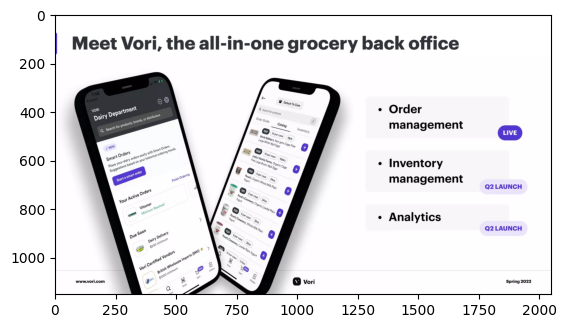

In [58]:
image_file = random.sample(image_paths,1)
print(image_file)
label = image_file[0].split('.')[0]
path = os.path.join(image_dataset, label)
image = os.path.join(path, image_file[0])
pic = ski.io.imread(image)
print(pic[0][:])
plt.imshow(pic)

### Number of slides per startup (max 30)

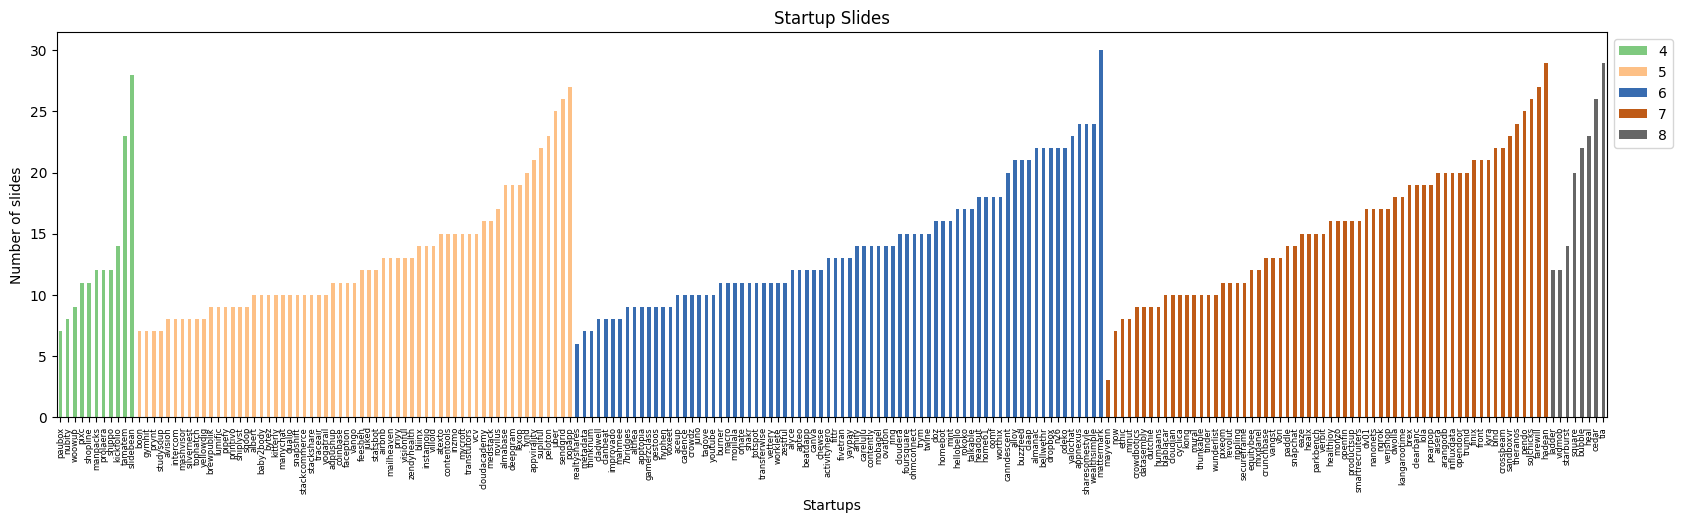

In [4]:
#df = df[df['Name'] != "mysql"] #remove mysql as it had 175 slides
#df = df[df['Name'] != "spotify"] #remove spotify as it had >50 slides
# Count occurrences of each Name
name_counts = df['Name'].value_counts()

# Filter rows where less than or equal to 30 slides
filtered_df = df.groupby('Name').filter(lambda x: name_counts[x.name] <= 30)

#count_slides = df.groupby('Name')['Name'].count()
#count_slides = df.groupby(['Name', 'Label']).size().unstack(fill_value=0)
count_slides = filtered_df.groupby(['Name', 'Label']).size().unstack(fill_value=0)
count_slides = count_slides.sort_values(by=list(count_slides.columns)[::-1], axis=0, ascending=True)

fig, ax = plt.subplots(figsize=(20, 5))

# Horizontal Bar/stacked Plot
count_slides.plot(kind='bar', stacked=True, colormap='Accent', ax=ax)


plt.xlabel('Startups')
plt.ylabel('Number of slides')
plt.title('Startup Slides')

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=6)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show Plot
plt.show()

### Sample size to balance

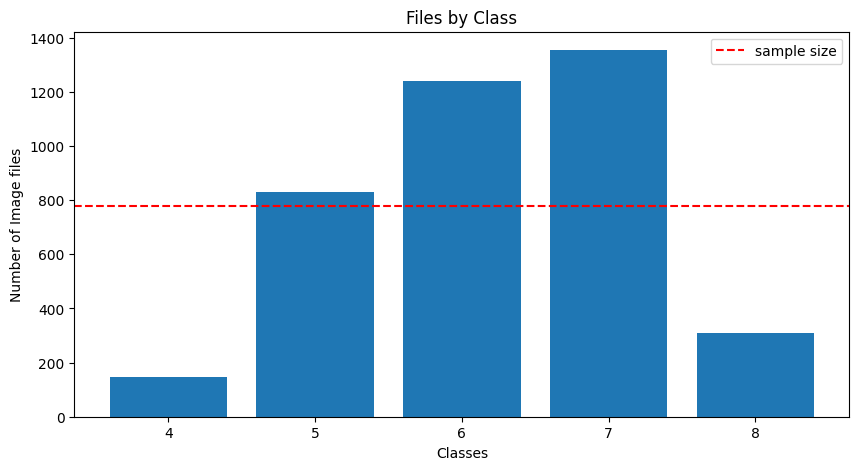

In [5]:
# Figure Size
fig, ax = plt.subplots(figsize=(10, 5))

# Horizontal Bar Plot
bars = ax.bar(target_classes, class_count)
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Image files')
ax.set_title('Files by Class')

# Draw a horizontal line at y-coordinate 777
ax.axhline(y=sample_size, color='red', linestyle='--', label='sample size')

# Show Plot
plt.legend()
plt.show()

### Images by class, stacked by startup

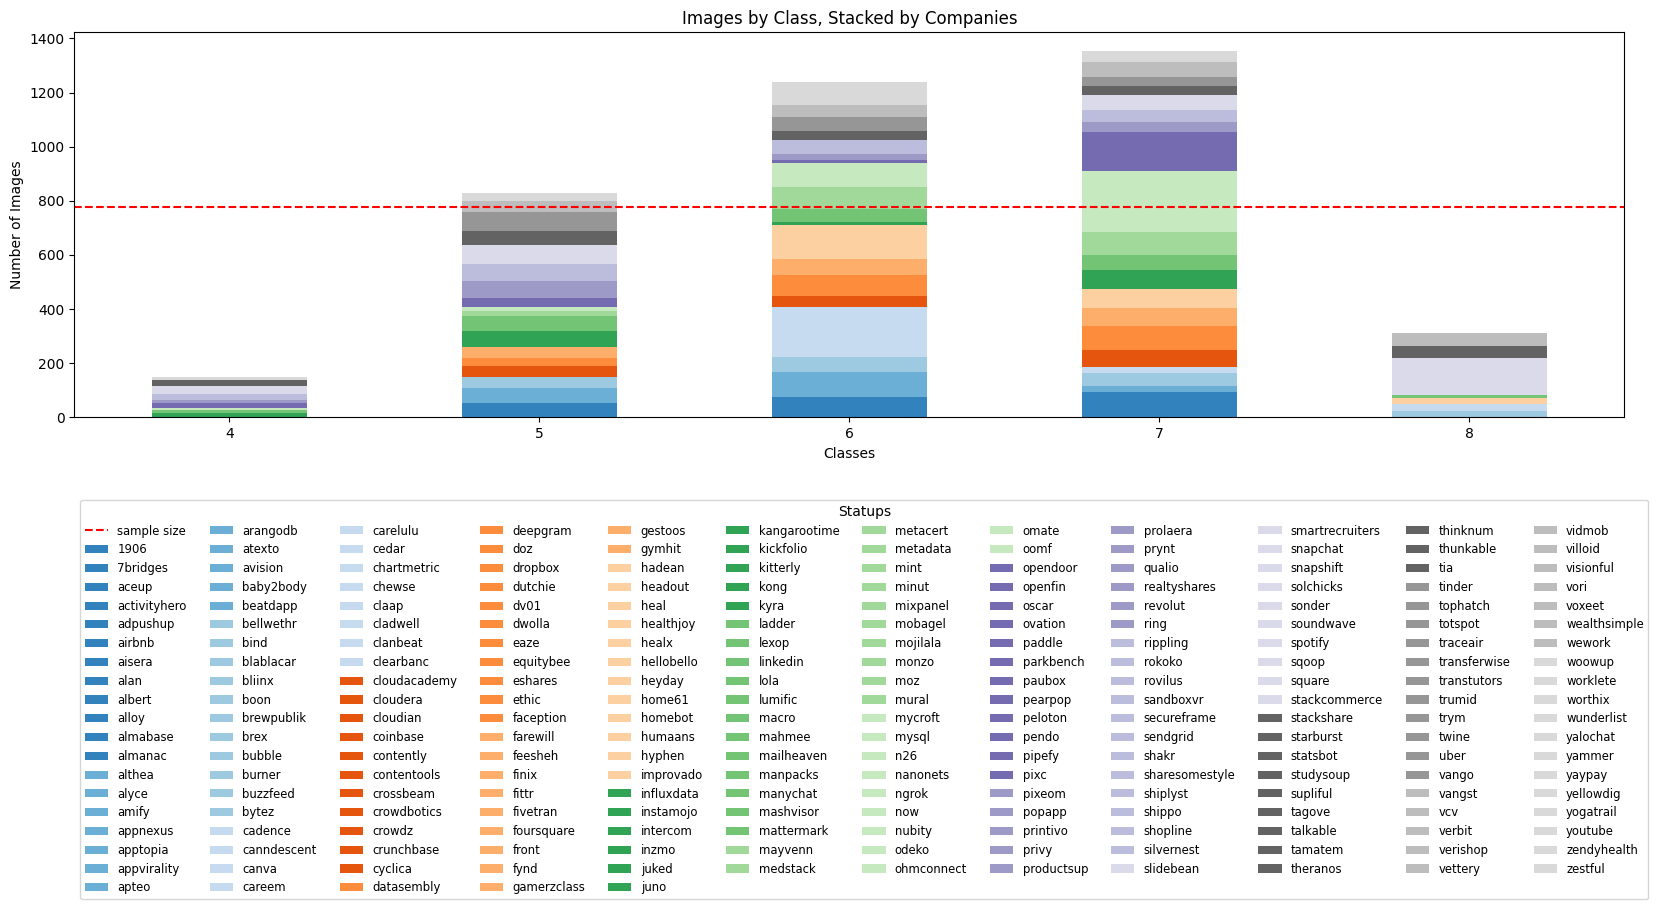

In [6]:
# Count the frequency of each Name for each Label
count_df = df.groupby(['Label', 'Name']).size().unstack(fill_value=0)

# Plotting a stacked bar chart
ax = count_df.plot(kind='bar', stacked=True, colormap='tab20c', figsize=(20, 5))

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Images by Class, Stacked by Companies')

# Draw a horizontal line at y-coordinate 777
ax.axhline(y=sample_size, color='red', linestyle='--', label='sample size')

# Rotate x-axis labels
plt.xticks(rotation=0)


# Add a legend with two columns
ax.legend(loc='upper left', bbox_to_anchor=(0, -0.2), fontsize='small', ncol=12, title='Statups')

# Hide the legend, too many startups
#ax.legend().set_visible(False)

# Show the plot
plt.show()

## Create Balanced Dataset

In [7]:
#print("dataset size: " + str(len(filtered_df)))
#print("sample size: " + str(sample_size) + "\n")
#for index, row in df.iterrows():
#    print(row['c1'], row['c2'])
balanced_df = pd.DataFrame(columns=['Name','Slide','Label','Path'])
for target_class in target_classes:

    #get current number of images in class
    count = len(filtered_df[filtered_df['Label'] == target_class])

    #print("target: " + target_class)
    #print(f"Count before: {count}")

    # Get unique startups for class.
    unique_startups = filtered_df[filtered_df['Label'] == target_class]['Name'].unique()

    while count<=sample_size:
        #randomly get half of startup names
        random_startups = np.random.choice(unique_startups, round(len(unique_startups)/2))

        #copy the startup images
        copied_df = filtered_df[filtered_df['Name'].isin(random_startups)].copy()
        filtered_df = pd.concat([filtered_df, copied_df], ignore_index=True)
        #update count to end while loop if oversampled
        count = len(filtered_df[filtered_df['Label'] == target_class])
    count = len(filtered_df[filtered_df['Label'] == target_class])
    #print(f"Count during: {count}")
    
    #randomly sample new oversampled dataset to create a balanced dataset
    sampled_df = filtered_df[filtered_df['Label'] == target_class].sample(n=sample_size, replace=True)
    #add sample to balanced dataset
    #print("sampled: " + str(len(sampled_df)))

    #print("Before concatenation:", balanced_df.shape)
    balanced_df = pd.concat([balanced_df, sampled_df], ignore_index=True)
    #print("After concatenation:", balanced_df.shape)

    count = len(balanced_df[balanced_df['Label'] == target_class])
    #print(f"Count after: {count}\n")

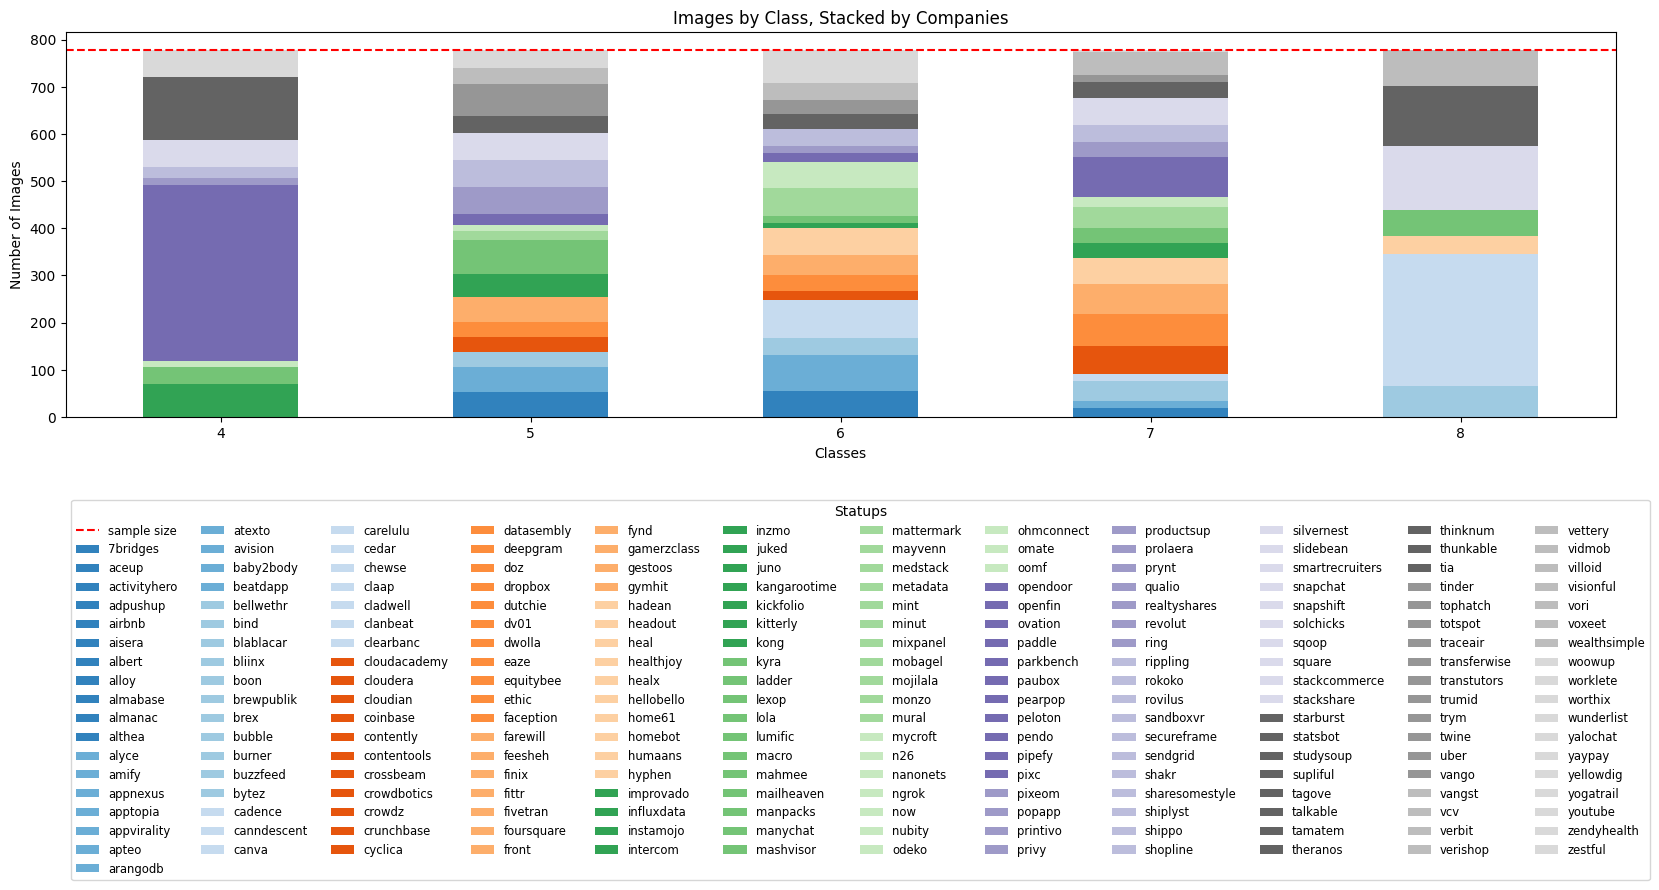

In [8]:
# Count the frequency of each Name for each Label
count_df = balanced_df.groupby(['Label', 'Name']).size().unstack(fill_value=0)

# Plotting a stacked bar chart
ax = count_df.plot(kind='bar', stacked=True, colormap='tab20c', figsize=(20, 5))

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Images by Class, Stacked by Companies')

# Draw a horizontal line at y-coordinate 777
ax.axhline(y=sample_size, color='red', linestyle='--', label='sample size')

# Rotate x-axis labels
plt.xticks(rotation=0)


# Add a legend with two columns
ax.legend(loc='upper left', bbox_to_anchor=(0, -0.2), fontsize='small', ncol=12, title='Statups')

# Hide the legend, too many startups
#ax.legend().set_visible(False)

# Show the plot
plt.show()

In [13]:
# Create directories for training and testing
train_dir = os.path.join(image_dataset, 'training_set')
test_dir = os.path.join(image_dataset, 'test_set')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for c in target_classes:
    train_c_folder = os.path.join(train_dir, c)
    test_c_folder = os.path.join(test_dir, c)
    os.makedirs(train_c_folder, exist_ok=True)
    os.makedirs(test_c_folder, exist_ok=True)

In [10]:
for target_class in target_classes:
    print("processing class: " + str(target_class))
    class_dir = os.path.join(image_dataset, target_class)
    files = os.listdir(class_dir)  # 4.kickfolio.01.jpg
    # get class sample dataset
    sample = balanced_df[balanced_df['Label'] == target_class]

    for index, row in sample.iterrows(): #777 times
        file = row["Path"]  # 4.manpacks.12.jpg

        #if file exist in start folder create copy
        if file in files:
            #location of file to copy
            src_path = os.path.join(class_dir, file)
            #rename copied file
            file_name, file_extension = os.path.splitext(file)
            copy = 1
            copy_file = file_name + "." + str(copy).rjust(2,'0') + file_extension # 4.manpacks.12.01.jpg

            # Check if the copy already exists, increment copy until a unique filename is found
            target_dir = os.path.join(train_dir, target_class)
            target_files = os.listdir(target_dir)
            while copy_file in target_files:
                copy += 1
                copy_file = file_name + "." + str(copy).rjust(2,'0') + file_extension
            
            dest_path = os.path.join(target_dir, copy_file)

            #print("file: " + file + ", copy_file: " + copy_file)

            # copy files to the training folder
            shutil.copy(src_path, dest_path)
            print("\t" + copy_file)


processing class: 4
	4.pixc.02.01.jpg
	4.manpacks.08.01.jpg
	4.kickfolio.13.01.jpg
	4.shopline.11.01.jpg
	4.pixc.06.01.jpg
	4.slidebean.06.01.jpg
	4.pixc.02.02.jpg
	4.prolaera.01.01.jpg
	4.manpacks.02.01.jpg
	4.paubox.03.01.jpg
	4.shippo.05.01.jpg
	4.paubox.03.02.jpg
	4.pixc.02.03.jpg
	4.kickfolio.04.01.jpg
	4.manpacks.09.01.jpg
	4.paubox.01.01.jpg
	4.kickfolio.01.01.jpg
	4.pixc.08.01.jpg
	4.tamatem.09.01.jpg
	4.pixc.10.01.jpg
	4.tamatem.11.01.jpg
	4.pixc.02.04.jpg
	4.paubox.01.02.jpg
	4.pixc.01.01.jpg
	4.paubox.01.03.jpg
	4.pixc.05.01.jpg
	4.kickfolio.09.01.jpg
	4.woowup.06.01.jpg
	4.paubox.03.03.jpg
	4.paubox.02.01.jpg
	4.tamatem.02.01.jpg
	4.tamatem.22.01.jpg
	4.paubox.06.01.jpg
	4.pixc.10.02.jpg
	4.pixc.09.01.jpg
	4.pixc.06.02.jpg
	4.kickfolio.04.02.jpg
	4.pixc.03.01.jpg
	4.woowup.08.01.jpg
	4.woowup.09.01.jpg
	4.tamatem.12.01.jpg
	4.paubox.02.02.jpg
	4.woowup.03.01.jpg
	4.pixc.05.02.jpg
	4.woowup.06.02.jpg
	4.pixc.11.01.jpg
	4.pixc.07.01.jpg
	4.paubox.06.02.jpg
	4.pixc.11.02.jpg
	

In [11]:
class_count = []
for label in target_classes:
    label_path = os.path.join(train_dir, label)
    count = len([image_path for image_path in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, image_path))])
    class_count.append(count)
print(target_classes) #['4', '5', '6', '7', '8']
print(class_count) #[147, 831, 1240, 1355, 311]

['4', '5', '6', '7', '8']
[777, 777, 777, 777, 777]


In [14]:
# Split the training data into training and testing sets
for target_class in target_classes:
    print("processing class: " + str(target_class))
    class_dir = os.path.join(train_dir, target_class)
    #get a list of all images in training folder
    files = os.listdir(class_dir)
    
    #split training folder
    _ , test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    #move selected test files to test folder
    for file in test_files:
        print
        src_path = os.path.join(class_dir, file)
        dest_path = os.path.join(test_dir, target_class, file)
        shutil.move(src_path, dest_path)
        print("\t" + file)

processing class: 4
	4.slidebean.20.01.jpg
	4.slidebean.02.01.jpg
	4.tamatem.05.01.jpg
	4.nubity.02.02.jpg
	4.slidebean.28.01.jpg
	4.pixc.01.03.jpg
	4.shippo.09.01.jpg
	4.pixc.07.16.jpg
	4.pixc.11.16.jpg
	4.pixc.11.02.jpg
	4.tamatem.07.03.jpg
	4.manpacks.04.03.jpg
	4.pixc.06.17.jpg
	4.pixc.06.23.jpg
	4.pixc.06.22.jpg
	4.tamatem.18.01.jpg
	4.shippo.04.03.jpg
	4.kickfolio.13.09.jpg
	4.tamatem.07.02.jpg
	4.kickfolio.14.01.jpg
	4.manpacks.08.02.jpg
	4.woowup.03.02.jpg
	4.slidebean.25.01.jpg
	4.tamatem.03.04.jpg
	4.kickfolio.06.02.jpg
	4.pixc.06.13.jpg
	4.manpacks.04.04.jpg
	4.pixc.10.06.jpg
	4.pixc.10.26.jpg
	4.prolaera.05.02.jpg
	4.paubox.05.02.jpg
	4.woowup.08.04.jpg
	4.tamatem.09.01.jpg
	4.pixc.02.26.jpg
	4.pixc.09.14.jpg
	4.pixc.05.12.jpg
	4.pixc.03.02.jpg
	4.shopline.01.01.jpg
	4.slidebean.11.02.jpg
	4.pixc.10.17.jpg
	4.tamatem.02.04.jpg
	4.woowup.09.07.jpg
	4.tamatem.16.05.jpg
	4.slidebean.22.01.jpg
	4.slidebean.08.02.jpg
	4.pixc.10.04.jpg
	4.pixc.02.09.jpg
	4.pixc.10.21.jpg
	4.paubo

In [15]:
train_count = []
test_count = []
for label in target_classes:
    label_path = os.path.join(train_dir, label)
    count = len([image_path for image_path in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, image_path))])
    train_count.append(count)

for label in target_classes:
    label_path = os.path.join(test_dir, label)
    count = len([image_path for image_path in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, image_path))])
    test_count.append(count)
print(target_classes) #['4', '5', '6', '7', '8']
print(train_count) #[147, 831, 1240, 1355, 311]
print(test_count) #[147, 831, 1240, 1355, 311]

['4', '5', '6', '7', '8']
[621, 621, 621, 621, 621]
[156, 156, 156, 156, 156]


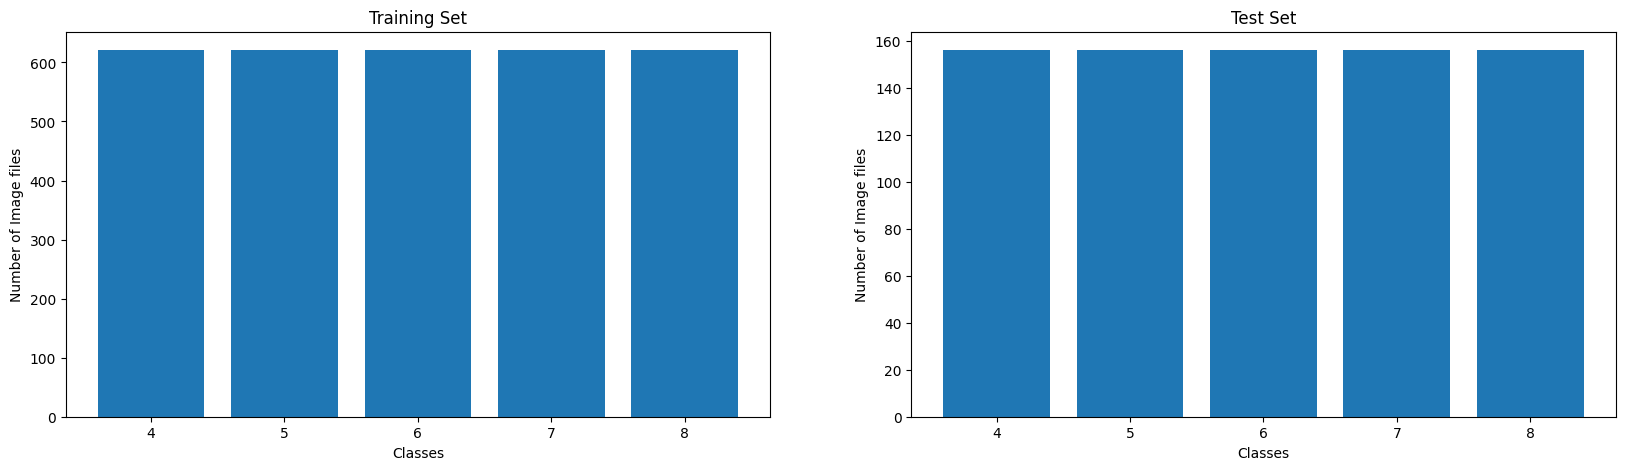

In [26]:
# Figure Size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Horizontal Bar Plot
bars = ax1.bar(target_classes, train_count)
ax1.set_xlabel('Classes')
ax1.set_ylabel('Number of Image files')
ax1.set_title('Training Set')


# Horizontal Bar Plot
bars = ax2.bar(target_classes, test_count)
ax2.set_xlabel('Classes')
ax2.set_ylabel('Number of Image files')
ax2.set_title('Test Set')

# Show Plot
plt.show()